In [3]:
# run only if you have not installed the next libraries
"""
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install getdist
"""


'\n!pip install numpy\n!pip install matplotlib\n!pip install scipy\n!pip install getdist\n'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as sci
import time
from getdist import plots, MCSamples
import time
%matplotlib inline

# Gradiente de U

$\LARGE U = -\log(L(\textbf{q})p(\textbf{q})) = - \log(L) -  \log(p)$

$\LARGE \nabla_{q} U = -\frac{1}{L}\frac{\partial L}{\partial q} - \frac{1}{p}\frac{\partial p}{\partial q} = -\frac{1}{L}\frac{\partial L}{\partial q}$

Si el prior $p$ es uniforme, $\frac{\partial p}{\partial q} = 0$

$\LARGE \frac{\partial L}{\partial q} = \frac{\partial}{\partial q}(N\exp(-\frac{\chi^{2}}{2})) = -N \chi \exp(-\frac{\chi^{2}}{2})\frac{\partial \chi}{\partial q}$

$\LARGE \frac{\partial \chi}{\partial q} = \frac{\partial}{\partial q}(A - \frac{B^{2}}{C}) = \frac{\partial A}{\partial q} - 2\frac{B}{C} \frac{\partial B}{\partial q}$

$\LARGE \frac{\partial A}{\partial q} = \frac{\partial}{\partial q}(\sum_{i}\frac{(\mu_{i} - \mu)^{2}}{\sigma_{i}^{2}}) = -\sum_{i}\frac{2(\mu_{i} - \mu)}{\sigma_{i}^{2}} \frac{\partial \mu}{\partial q}$

$\LARGE \frac{\partial B}{\partial q} = \frac{\partial}{\partial q}(\sum_{i}\frac{(\mu_{i} - \mu)}{\sigma_{i}^{2}}) = - \sum_{i} \frac{1}{\sigma_{i}^{2}} \frac{\partial \mu}{\partial q}$

$\LARGE \frac{\partial \mu}{\partial q} = \frac{\partial}{\partial q} (5 \log_{10}(\bar{d}_{L})) = \frac{5}{\log{10}} \frac{1}{\bar{d}_{L}} \frac{\partial \bar{d}_{L}}{\partial q}$

$\LARGE \frac{\partial \bar{d}_{L}}{\partial q} = \frac{\partial}{\partial q}(\frac{d_{L}}{d_{H}}) = \frac{1}{d_{H}} \frac{\partial d_{L}}{\partial q}$

$\LARGE \frac{\partial d_{L}}{\partial q} = \frac{\partial}{\partial q}((1 + z)\, d_{M}) = (1 + z)\frac{\partial d_{M}}{\partial q}$

$
\begin{eqnarray}
\frac{\partial\ d_{M}}{\partial q} & = &  \left\{
	\begin{array}{ll}
		\frac{\partial f_{1}}{\partial q} & \mbox{if } \Omega_{k} > 0 \\
		\frac{\partial f_{2}}{\partial q} & \mbox{if } \Omega_{k} = 0 \\
        \frac{\partial f_{3}}{\partial q} & \mbox{if } \Omega_{k} < 0 
	\end{array}
\right.
\end{eqnarray}
$

\begin{align}
        \frac{\partial f_{1}}{\partial q} = \frac{\partial}{\partial q}(\frac{d_{H}}{\sqrt\Omega_{k}}\sinh(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E[z']}))\\
        \frac{\partial f_{1}}{\partial q} = d_{H} [-\frac{1}{2}\Omega_{k}^{-3/2}\frac{\partial \Omega_{k}}{\partial q}\sinh(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E(z')}) + \Omega_{k}^{-1/2}\cosh(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E(z')})\frac{\partial}{\partial q}(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E(z')})
\end{align}


In [2]:
# Este programa implementa Hamiltonian Markov Chain Monte Carlo. El núcleo utilizado se basa en Metropolis Hastings.

class PID:
    def __init__(self, kp, ki, kd, o_min, o_max):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.e0 = 0
        self.inte = 0
        self.out = 0
        self.min = o_min
        self.max = o_max

    def set_out(self, e):
        prop = e*self.kp
        deri = (e - self.e0)*self.kd
        if self.out!=1 and self.out!=0: # antiwind up
            self.inte += e*self.ki
        self.out = prop + deri + self.inte
        if self.out>self.max:
            self.out = self.max
        elif self.out<self.min:
            self.out = self.min
   
            
    def set_kp(self, kp):
        self.kp = kp

    def set_ki(self, ki):
        self.ki = ki

    def set_kd(self, kd):
        self.kd = kd


def likelihood(mod, dat, sigma): # retorna escalar, log(L)
    sig = np.diagonal(sigma)
    L = -0.5*chi2(mod, dat, sigma)[0]  + np.sum(-0.5*np.log(2*np.pi*sig**2))
    #pp = np.argwhere((a1==-np.inf))
    #a1[pp] = 0
    return L


def chi2(mod, dat, sigma):
    sig = np.diagonal(sigma)
    AA = np.sum(((dat - mod)/sig)**2)
    BB = np.sum((dat - mod)/sig**2)	
    CC = np.sum(1/sig**2)
    chi = AA - (BB**2)/CC
    return chi, BB/CC


def prior(theta): # log(pi)
    ct = 1
    r = np.diag(np.ones(len(theta))*ct)
    p = -0.5*np.log(np.linalg.det(2*np.pi*r)) - 0.5*theta.dot((np.linalg.inv(r)).dot(theta)) 
    return p


def acepta_hmc(ec, ep, EC, EP, x, X):
    alpha = min(- EP - EC + ep + ec, 0) # log(alpha)
    u = np.log(np.random.uniform())
    if u<alpha:
        return X, EP
    else:
        return x, ep
    
    
def acepta_mh(T1, pos1, T2, pos2, m1, m2):
    alpha = min(pos2 - pos1, 0) # log(alpha)
    u = np.log(np.random.uniform())
    if u<alpha:
        return T2, pos2, m2
    else:
        return T1, pos1, m1    


def EHubble(theta, z): # parametro de hubble
    om0 = theta[0]
    ol = theta[1]
    w = theta[2]
    arg = om0*(1 + z)**3 + (1 - om0 - ol)*(1 + z)**2 + ol*(1 + z)**(3*(1 + w))
    EE = np.sqrt(arg)
    return EE, arg


def modelo(theta,z): # modulo de la distancia teorico
    om0 = theta[0]
    ol = theta[1]
    omega_k = 1 - om0 - ol
    E = EHubble(theta, z)[0]
    I = sci.cumtrapz(1/(E + 1e-300), z, initial=0)+z[0]*((1/(E + 1e-300))[0] + 1)/2 # estabilidad numerica
    o_k_s = np.sqrt(abs(omega_k))
    if omega_k==0:
        dl = (1 + z)*I
    elif omega_k<0:
        dl = (1 + z)*np.sin(o_k_s*I)/(o_k_s + 1e-300) # estabilidad numerica
    elif omega_k>0:	
        dl = (1 + z)*np.sinh(o_k_s*I)/(o_k_s + 1e-300) # estabilidad numerica
    dist = 5*np.log10(dl + 1e-300) # estabilidad numerica
    #f (-np.inf==dist).any(): 
    #    print(theta)
    return dist


def tasa(tant, tpos):
    l = len(tant)
    if np.sum(tant==tpos)==l:
        c = 0
    else:
        c = 1
    return c


def revisa(theta, z):
    arg = EHubble(theta, z)[1]
    bol = np.sum(arg<0)
    print(bol)
    if bol>0:
        a = 0 # raiz imaginaria 
    else:
        a = 1 # raiz real
    return a


def argmin2(t1, t2, t3, V): # busca en base a vector chi2 y devulve minimos de los parametros
    amin = np.argmin(V)
    return t1[amin], t2[amin], t3[amin]


def revisa1(X):
    x = X[0]
    y = X[1]
    z = X[2]
    xlim = np.array([0, 1])
    ylim = xlim
    zlim = np.array([-np.inf, 1/3])
    if xlim[0]<x<xlim[1] and ylim[0]<y<ylim[1] and zlim[0]<z<zlim[1]:
        return 1
    else:
        return 0


def potencial(dat, sigma, theta, z):
    mod = modelo(theta, z)
    u = - likelihood(mod, dat, sigma) - prior(theta) 
    return u


def cinetica(p, m):
    k = np.sum(p**2/2/m)
    return k


def hamiltoniano(p, dat, sigma, theta, z, m=1):
    h = cinetica(p, m) + potencial(dat, sigma, theta, z)
    return h


def gradiente(dw, theta, z, dat, sigma):
    tf = theta + dw
    tb = theta - dw
    grad = (potencial(dat, sigma, tf, z) - potencial(dat, sigma, tb, z))/(2*dw)
    return grad


def leapfrog(l, e, dw, theta, m, z, dat, sigma):

    qe = theta
    while True:

        pi = np.random.multivariate_normal(mean=np.zeros(3), cov=np.diag(m))
        pe = pi
        X = []
        P = []
        X.append(theta)
        P.append(pe)
        for i in range(l):
  
            #print(i)
            #rev = revisa1(qe)*revisa1(qe + dw)*revisa1(qe - dw) # revisa(qe, z)*revisa(qe + 0.5*dw, z)*revisa(qe - 0.5*dw, z)
            #print(rev)
            #if rev:
            #    break            
            #print('ant pe', pe)
            #print('ant qe', qe)
            #print('grad', gradiente(dw, qe, z, dat, sigma))
            pe = pe - 0.5*e*gradiente(dw, qe, z, dat, sigma) # actualiza momento en e/2
            
            #print('desp pe', pe)
            
            qe = qe + e*pe/m
            if qe[0]<0:
                qe[0] = qe[0]*-1
                pe[0] = pe[0]*-1
            if qe[1]<0:
                qe[1] = qe[1]*-1
                pe[1] = pe[1]*-1
            if qe[2]>1/3:
                qe[2] = 1/3 - qe[2]
                pe[2] = pe[2]*-1
      
            #rev = revisa1(qe)*revisa1(qe + dw)*revisa1(qe - dw) # revisa(qe, z)*revisa(qe + 0.5*dw, z)*revisa(qe - 0.5*dw, z)
            #print(rev)
            #if rev:
            #    break

            pe = pe - 0.5*e*gradiente(dw, qe, z, dat, sigma)

            P.append(pe)
            X.append(qe)
            if i + 1==l: 
                i += 1
        if i==l: 
            break

    P = np.array(P)
    X = np.array(X)
    return X, P
    
    
def HMC(modelo, datos, ds, dg, N, L, params, q0, cov_mod, m, des=0.24):
    """
    datos: X, F(X)
    params: ['p1', 'p2', ..., 'pn']
    cov: matriz de covarianza de datos
    """
    # Matrices de datos de la cadena
    pid0 = PID(kp=10, ki=10, kd=10, o_min=1e-4, o_max=1e1)
    X = datos[0]
    Y = datos[1]
    chain = [] 
    post = [] 
    chi_2 = []
    Ratio = []
    H = []
    acept = 0
    mod1 = modelo(q0, X)
    pos1 = potencial(Y, cov_mod, q0, X)
    Chi1 = chi2(mod1, Y, cov_mod)[0]
    chain.append(q0)
    post.append(pos1)
    chi_2.append(Chi1)
    Ratio.append(100)

    Ti = time.time()
    for i in range(N):
        #error = des - Ratio[-1]/100
        #pid0.set_out(error)
        #m[0] = pid0.out
        q = chain[i]
        while True:
            Q, P = leapfrog(L, ds, dg, q, m, X, Y, cov)
            Q1 = Q[-1]
            P1 = P[-1]
            if revisa1(Q1):
                break
        H.append(Q)
        t = cinetica(P1[0], m)
        u = potencial(Y, cov_mod, q, X)
        T = cinetica(P1, m)
        U = potencial(Y, cov_mod, Q1, X)
        A = acepta_hmc(t, u, T, U, q, Q1)
        chain.append(A[0])
        post.append(A[1])
        mod1 = modelo(A[0], X)
        Chi1 = chi2(mod1, Y, cov_mod)[0]
        chi_2.append(Chi1)
        # ratio de aceptacion
        acept += tasa(chain[i], chain[i + 1]) 
        Ratio.append(acept/(i+1)*100)
        if i%10==0:
            print(i)
            print('ratio', Ratio[i])

    Tf = time.time()
    print('Tiempo cadena', np.around(Tf - Ti, 0), 's')

    ratio = acept/N*100
    print('ratio %', np.rint(ratio))

    post = np.array(post)
    chain = np.array(chain)
    chi_2 = np.array(chi_2)
    Ratio = np.array(Ratio)
    H = np.array(H)

    t1 = chain[:,0]
    t2 = chain[:,1]
    t3 = chain[:,2]

    # busca argumento del minimo de chi2
    t1m, t2m, t3m = np.around(argmin2(t1, t2, t3, chi_2),3)
    mins = [t1m, t2m, t3m]
    muestras = {}
    for i in range(len(params)):
        muestras[params[i]] = chain[:, i]
    return muestras, Ratio, chi_2, post, mins


def MH(modelo, datos, N, params, q0, cov_mod, cov_prop, des=0.24):
    """
    datos: X, F(X)
    params: ['p1', 'p2', ..., 'pn']
    cov: matriz de covarianza de datos
    """
    # Matrices de datos de la cadena
    #pid = PID(kp=10, ki=10, kd=10, o_min=2, o_max=20)
    T0 = q0
    X = datos[0]
    Y = datos[1]
    chain = [] 
    post = [] 
    chi_2 = []
    Ratio = []
    mod = []
    acept = 0
    mod0 = modelo(T0, X)
    chi0 = chi2(mod0, Y, cov_mod)[0]
    pos0 = likelihood(mod0, Y, cov_mod) + prior(T0)
    mod.append(mod0)
    chain.append(T0)
    post.append(pos0)
    chi_2.append(chi0)
    Ratio.append(100)

    # pasos de cadena
    Ti = time.time()
    for i in range(N):
        # revisa si se paso umbral de burn in
        """	
        if chi_2[i]<=580 and d==0 and o!=0:
            covarianza = COV[o]
            d = 1
            print('actualizada')
            print(covarianza)
        """	
        # selecciona ultimo elemento de la cadena
        T0 = chain[i]
        # itera hasta que encuentra un proposal valido
        while True:
            T1 = np.random.multivariate_normal(mean=T0, cov=cov_prop)
            if revisa1(T1):
                break
        # selecciona ultimo modelo
        mod0 = mod[i]
        # calcula modelo con proposal
        mod1 = modelo(T1, X)
        # selecciona ultima dis. post.
        pos0 = post[i]
        # calcula nueva dist. post.
        pos1 = likelihood(mod1, Y, cov_mod) + prior(T1)
        # decision de aceptacion
        A = acepta_mh(T0, pos0, T1, pos1, mod1, mod1)
        # guarda la variable aceptada (puede ser la anterior o proposal)
        chain.append(A[0])
        post.append(A[1])
        mod.append(A[2])
        chi_2.append(chi2(A[2], Y, cov)[0])
        # ratio de aceptacion
        acept += tasa(chain[i], chain[i + 1]) 
        Ratio.append(acept/(i+1)*100)
        if i%100==0:
            print(i)
            print('ratio', Ratio[i])

    Tf = time.time()
    print('Tiempo cadena', np.around(Tf - Ti, 0), 's')
    
    ratio = acept/N*100
    print('ratio %', np.rint(ratio))

    post = np.array(post)
    chain = np.array(chain)
    chi_2 = np.array(chi_2)
    Ratio = np.array(Ratio)
  
    t1 = chain[:,0]
    t2 = chain[:,1]
    t3 = chain[:,2]

    # busca argumento del minimo de chi2
    t1m, t2m, t3m = np.around(argmin2(t1, t2, t3, chi_2),3)
    mins = [t1m, t2m, t3m]
    muestras = {}
    for i in range(len(params)):
        muestras[params[i]] = chain[:, i]
    return muestras, Ratio, chi_2, post, mins

In [3]:
# saved things directory
direc = '/home/mauricio/Documents/Uni/Intro_2/' + 'gal.txt'

# Carga de datos
redshift = np.genfromtxt('gal.txt', usecols=(1))
mu_obs = np.genfromtxt('gal.txt', usecols=(2)) # m - M
cov = np.genfromtxt('gal.txt', usecols=(3))

p = np.argsort(redshift)
redshift = redshift[p]
mu_obs = mu_obs[p]
cov = cov[p]
cov = np.diag(cov)

In [4]:
# configuracion cadena

# params
labs = [r'$\Omega_{m}$', r'$\Omega_{\Lambda}$', r'w']
labs1 = [r'\Omega_{m}', r'\Omega_{\Lambda}', r'w']

M = -19.3182761161

## Metroplis-Hastings

In [641]:
# covarianza inicial
cov_ini = np.diag(np.array([0.4, 1.125, 4])**2)*0.5e-2
print(np.diag(cov_ini))
q0 = np.random.uniform(low=[0,0,-5], high=[1, 1, 1/3], size=3)
print('q0', q0)
R_mh = MH(modelo, [redshift, mu_obs], N=2000, params=['om', 'ol', 'w'], q0=q0, cov_mod=cov, cov_prop=cov_ini)

[0.0008     0.00632813 0.08      ]
q0 [ 0.0161997   0.80172314 -4.65778968]
0
ratio 100
100
ratio 42.0
200
ratio 32.5
300
ratio 30.333333333333336
400
ratio 31.75
500
ratio 28.999999999999996
600
ratio 27.833333333333332
700
ratio 27.714285714285715
800
ratio 27.875
900
ratio 28.22222222222222
1000
ratio 28.299999999999997
1100
ratio 28.000000000000004
1200
ratio 28.833333333333332
1300
ratio 28.076923076923077
1400
ratio 27.785714285714285
1500
ratio 26.93333333333333
1600
ratio 26.25
1700
ratio 25.647058823529413
1800
ratio 25.666666666666664
1900
ratio 25.210526315789473
Tiempo cadena 3.0 s
ratio % 25.0


## Hamiltonian Monte Carlo

In [645]:
ds = 1e-2
m = np.array([1, 1, 1])
print('q0', q0)
R_hmc = HMC(modelo, [redshift, mu_obs], ds=ds, dg=1e-6, N=2000, L=5, params=['om', 'ol', 'w'], 
            q0=q0, cov_mod=cov, m=m)


q0 [ 0.0161997   0.80172314 -4.65778968]
0
ratio 100
10
ratio 70.0
20
ratio 55.00000000000001
30
ratio 56.666666666666664
40
ratio 55.00000000000001
50
ratio 60.0
60
ratio 61.66666666666667
70
ratio 62.857142857142854
80
ratio 63.74999999999999
90
ratio 64.44444444444444
100
ratio 65.0
110
ratio 63.63636363636363
120
ratio 62.5
130
ratio 61.53846153846154
140
ratio 60.0
150
ratio 60.0
160
ratio 59.375
170
ratio 59.411764705882355
180
ratio 58.88888888888889
190
ratio 57.36842105263158
200
ratio 56.49999999999999
210
ratio 56.666666666666664
220
ratio 57.72727272727273
230
ratio 58.26086956521739
240
ratio 59.166666666666664
250
ratio 58.8
260
ratio 58.07692307692308
270
ratio 59.25925925925925
280
ratio 59.285714285714285
290
ratio 58.27586206896552
300
ratio 57.333333333333336
310
ratio 56.451612903225815
320
ratio 56.875
330
ratio 56.666666666666664
340
ratio 56.76470588235294
350
ratio 56.00000000000001
360
ratio 56.388888888888886
370
ratio 56.486486486486484
380
ratio 56.315789473

## Resultados

Text(0,0.5,'$\\Omega_{\\Lambda}$')

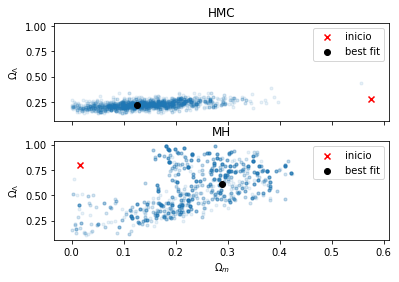

In [642]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)

ax1.scatter(R_hmc[0]['om'], R_hmc[0]['ol'], marker='.', alpha=0.1)
ax1.scatter(R_hmc[0]['om'][0], R_hmc[0]['ol'][0], marker='x', color='red', alpha=1, label='inicio')
ax1.scatter(R_hmc[4][0], R_hmc[4][1], marker='o', color='black', alpha=1, label='best fit')
ax2.scatter(R_mh[0]['om'], R_mh[0]['ol'], marker='.', alpha=0.1)
ax2.scatter(R_mh[0]['om'][0], R_mh[0]['ol'][0], marker='x', color='red', alpha=1, label='inicio')
ax2.scatter(R_mh[4][0], R_mh[4][1], marker='o', color='black', alpha=1, label='best fit')

ax1.set_title('HMC')
ax2.set_title('MH')

ax1.legend()
ax2.legend()
ax2.set_xlabel(r'$\Omega_{m}$')
ax2.set_ylabel(r'$\Omega_{\Lambda}$')
ax1.set_ylabel(r'$\Omega_{\Lambda}$')

Text(0,0.5,'$\\omega$')

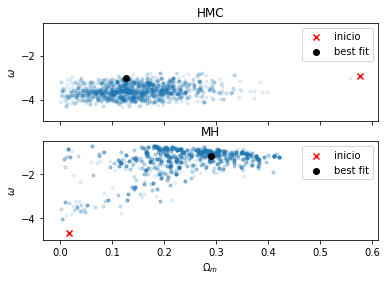

In [643]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)

ax1.scatter(R_hmc[0]['om'], R_hmc[0]['w'], marker='.', alpha=0.1)
ax1.scatter(R_hmc[0]['om'][0], R_hmc[0]['w'][0], marker='x', color='red', alpha=1, label='inicio')
ax1.scatter(R_hmc[4][0], R_hmc[4][2], marker='o', color='black', alpha=1, label='best fit')
ax2.scatter(R_mh[0]['om'], R_mh[0]['w'], marker='.', alpha=0.1)
ax2.scatter(R_mh[0]['om'][0], R_mh[0]['w'][0], marker='x', color='red', alpha=1, label='inicio')
ax2.scatter(R_mh[4][0], R_mh[4][2], marker='o', color='black', alpha=1, label='best fit')

ax1.set_title('HMC')
ax2.set_title('MH')

ax1.legend()
ax2.legend()
ax2.set_xlabel(r'$\Omega_{m}$')
ax2.set_ylabel(r'$\omega$')
ax1.set_ylabel(r'$\omega$')


Text(0,0.5,'$\\omega$')

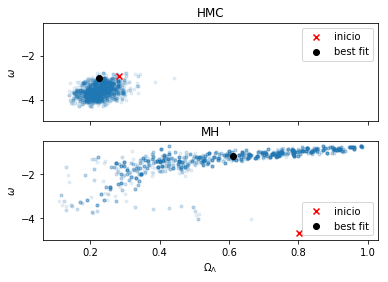

In [644]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)

ax1.scatter(R_hmc[0]['ol'], R_hmc[0]['w'], marker='.', alpha=0.1)
ax1.scatter(R_hmc[0]['ol'][0], R_hmc[0]['w'][0], marker='x', color='red', alpha=1, label='inicio')
ax1.scatter(R_hmc[4][1], R_hmc[4][2], marker='o', color='black', alpha=1, label='best fit')
ax2.scatter(R_mh[0]['ol'], R_mh[0]['w'], marker='.', alpha=0.1)
ax2.scatter(R_mh[0]['ol'][0], R_mh[0]['w'][0], marker='x', color='red', alpha=1, label='inicio')
ax2.scatter(R_mh[4][1], R_mh[4][2], marker='o', color='black', alpha=1, label='best fit')

ax1.set_title('HMC')
ax2.set_title('MH')

ax1.legend()
ax2.legend()
ax2.set_xlabel(r'$\Omega_{\Lambda}$')
ax2.set_ylabel(r'$\omega$')
ax1.set_ylabel(r'$\omega$')



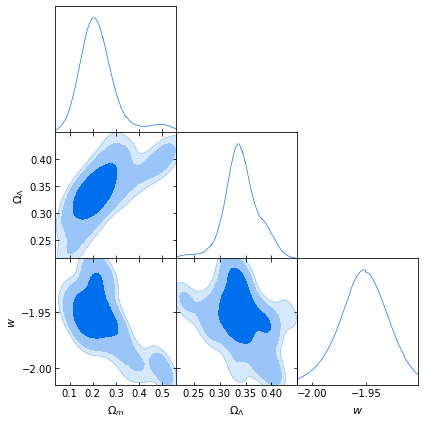

In [531]:
#Get the getdist MCSamples objects for the samples, specifying same parameter
#names and labels; if not specified weights are assumed to all be unity

ndim = 3
names = ["x%s"%i for i in range(ndim)]
labels = ["x_%s"%i for i in range(ndim)]
t1 = R[0]['om']
t2 = R[0]['ol']
t3 = R[0]['w']
samps = np.vstack((t1, t2, t3)).T
samples = MCSamples(samples=samps, names=labs1, labels=labs1)

#Triangle plot
g = plots.getSubplotPlotter()
samples.updateSettings({'contours': [0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 3
g.triangle_plot([samples], filled=True)


In [638]:
dw = 1e-6
e = 1e-2
l = 5
theta = q0

X, P = leapfrog(l=l, e=e, dw=dw, theta=q0, m=m, z=redshift, dat=mu_obs, sigma=cov)
XM = np.random.multivariate_normal(mean=q0, cov=cov_ini)
plt.plot(X[:, 0], X[:, 1])
plt.scatter(q0[0], q0[1], color='red')
plt.scatter(XM[0], XM[1], color='navy', label='MH')
plt.xlim([min(X[-1, 0], XM[0]) - 0.1, max(X[-1, 0], XM[0]) + 0.1])
plt.ylim([min(X[-1, 1], XM[1]) - 0.1, max(X[-1, 1], XM[1]) + 0.1])
plt.legend()
print(m)

om 0.012314202956113044
ol 0.10778583746814793
0.9380298287238732
0.879899959575739
om 0.012312202956113046
ol 0.10778383746814793
0.9380319608498098
0.8799039595757391
om inf
ol 0.09039434826994938
inf
-inf
om inf
ol 0.09039234826994938
inf
-inf
om inf
ol 0.09039434826994938
inf
-inf
om inf
ol 0.09039234826994938
inf
-inf
om nan
ol nan
nan
nan


/home/mauricio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:196: RuntimeWarning: divide by zero encountered in true_divide
/home/mauricio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in add


UnboundLocalError: local variable 'dl' referenced before assignment

In [639]:
X, P = leapfrog(l=l, e=e, dw=dw, theta=q0, m=m, z=redshift, dat=mu_obs, sigma=cov)
XM = np.random.multivariate_normal(mean=q0, cov=cov_ini)

m[2] = 10
m[0] = 1e0
plt.plot(X[:, 0], X[:, 2])
plt.scatter(q0[0], q0[2], color='red')
plt.scatter(XM[0], XM[2], color='navy', label='MH')
plt.xlim([min(X[-1, 0], XM[0]) - 0.1, max(X[-1, 0], XM[0]) + 0.1])
plt.ylim([min(X[-1, 2], XM[2]) - 0.1, max(X[-1, 2], XM[1]) + 0.1])
plt.legend()
print(m)

om 0.012314202956113044
ol 0.10778583746814793
0.9380298287238732
0.879899959575739
om 0.012312202956113046
ol 0.10778383746814793
0.9380319608498098
0.8799039595757391
om inf
ol 0.12170452641698214
inf
-inf
om inf
ol 0.12170252641698213
inf
-inf
om inf
ol 0.12170452641698214
inf
-inf
om inf
ol 0.12170252641698213
inf
-inf
om nan
ol nan
nan
nan


/home/mauricio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:196: RuntimeWarning: divide by zero encountered in true_divide
/home/mauricio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in add


UnboundLocalError: local variable 'dl' referenced before assignment

In [ ]:
redshift = np.genfromtxt('gal.txt', usecols=(1))
mu_obs = np.genfromtxt('gal.txt', usecols=(2)) # m - M

plt.scatter(redshift, mu_obs)
plt.xlabel('redshift')
plt.ylabel('magitud relativa')